# `Bike Sharing Demand Regression Analysis`
-------------------------------------------
### Project 중간발표
ABO3 = ["박준영", "백형렬", "신민규", "장보윤"]

In [57]:
%matplotlib inline

import statsmodels.api as sm
from datetime import datetime as dt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings("ignore")

df_train = pd.read_csv("train.csv", parse_dates=['datetime'])
df_test = pd.read_csv("test.csv", parse_dates=['datetime'])
df_raw = pd.read_csv("train.csv", parse_dates=['datetime'])
df_raw1 = df_raw[['temp', 'atemp', 'humidity', 'windspeed', 'count']]


def EDA_data(df):
    
    import statsmodels.api as sm
    from datetime import datetime as dt
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    from sklearn.metrics import r2_score
    from sklearn.model_selection import KFold
    
    # 보윤님
    df['year_month'] = df['datetime'].apply(lambda x: int(x.strftime('%y%m')))
    df['month_day'] = df['datetime'].apply(lambda x: int(x.strftime('%m%d')))
    def season_div(df):
        if df['month_day'] >= 1121 or df['month_day'] <= 310:
            df['season'] = 3
        elif df['month_day'] >= 311 and df['month_day'] <= 520:
            df['season'] = 1
        elif df['month_day'] >= 521 and df['month_day'] <= 910:
            df['season'] = 2
        else:
            df['season'] = 1
        return df['season']
    df['season1'] = df[['month_day','season']].apply(season_div, axis = 1)
    
    # 원래 기본 datetime parsing
    df['year'] = df['datetime'].dt.year
    df['month'] = df['datetime'].dt.month
    df['day'] = df['datetime'].dt.day
    df['hour'] = df['datetime'].dt.hour
    df['dayofweek'] = df['datetime'].dt.dayofweek
    df['datetime'] = df['datetime'].dt.strftime('%Y%m%d')
    df['weekend'] = df['dayofweek'].apply(lambda x: 1 if x >= 5 else 0)

            
    # WindSpeed 전처리
    df["before-windspeed"] = df["windspeed"].shift(+1) #1시간전 바람속도 (shift로 한칸 내림)
    df["after-windspeed"]= df["windspeed"].shift(-1) # 1시간후 바람속도 (shift로 한칸 올림)
    df['before-windspeed'] = df['before-windspeed'].fillna(0) # 내리면서 NaN값 생긴것 가장 근처 값으로 처리
    df['after-windspeed'] = df['after-windspeed'].fillna(df.loc[len(df)-1]['windspeed']) #마찬가지
    df['middle-windspeed']= (df['before-windspeed'] + df['after-windspeed']) / 2 # 중간 값
    df.loc[df["windspeed"] == 0, "windspeed"] = df.loc[df["windspeed"] == 0,"middle-windspeed"] #windspeed가 0인 row에 middle-windspeed를넣는다.
    df.drop('before-windspeed', axis=1, inplace=True)
    df.drop('after-windspeed', axis=1, inplace=True)
    df.drop('middle-windspeed', axis=1, inplace=True)
    
    def fill_wind(df):
        cond1 = df['windspeed'] == 0
        WinZeroDate = df[cond1]['datetime'].unique()
        i = 0
        while i < len(WinZeroDate):
            cond2 = df['datetime'] == WinZeroDate[i]
            mean = df[cond2]['windspeed'].mean()
            df.loc[cond1&cond2, 'windspeed'] = mean
            i += 1
        return df['windspeed']
    
    df['windspeed'] = fill_wind(df)
    
    def new_col(x, y):
        week_group = [[0, 1, 2, 3, 4, 5], [6, 10, 11, 21, 22, 23], [9, 12, 13, 14, 15, 20], [7, 8, 16, 17, 18, 19]]
        weekend_group = [[2, 3, 4, 5, 6, 7], [0, 1, 8, 21, 22, 23], [9, 10, 11, 18, 19, 20], [12, 13, 14, 15, 16, 17]]
        if y >= 5:
            if x in weekend_group[0]:
                return 1
            elif x in weekend_group[1]:
                return 2
            elif x in weekend_group[2]:
                return 3
            elif x in weekend_group[3]:
                return 4

        else:
            if x in week_group[0]:
                return 5
            elif x in week_group[1]:
                return 6
            elif x in week_group[2]:
                return 7
            elif x in week_group[3]:
                return 8
            
    df['new_col'] = df.apply(lambda x: new_col(x['hour'], x['dayofweek']), axis=1)
            
    # humidity
    df[df['humidity'] == 0]
    df['humidity'] = df['humidity'].apply(lambda x: 98.75 if x == 0 else x)
    
    # perfect atemp
    def change_3(df):
        return 13.12 + 0.6215*float(df['temp']) - 11.37*(float(df["windspeed"])**0.16) + 0.3965*float(df["temp"])*(float(df["windspeed"])**0.16)
    df['perfect_atemp'] = df.apply(lambda df: change_3(df), axis= 1)
    
    # adjusted_atemp
    def change_2(df):
        if df['atemp'] == 12.12:
            return 13.12 + 0.6215*float(df['temp']) - 11.37*(float(df["windspeed"])**0.16) + 0.3965*float(df["temp"])*(float(df["windspeed"])**0.16)
        else:
            return df['atemp']
    
    df['adjusted_atemp'] = df.apply(lambda df: change_2(df),axis= 1)
    
    # atemp_log
    df['atemp_log'] = df['atemp'].apply(lambda x: np.log(x))

    # new_month for atemp
    def NewMonth(x):
        if x in [1, 2]:
            return 1
        elif x in [3, 4]:
            return 2
        elif x in [5]:
            return 3
        elif x in [6]:
            return 4
        elif x in [7, 8]:
            return 5
        elif x in [9, 10]:
            return 6
        elif x in [11, 12]:
            return 7
    df['month'] = df['month'].map(lambda x: int(x))
    df['new_month'] = df.apply(lambda x: NewMonth(x['month']), axis=1)
    
    # new_month(combined with weekend)
    def NewMonthCol(x, y):
        
        week_group =  [[1, 2, 3], [4, 11, 12], [5, 6, 9], [7, 8, 10]]
        weekend_group = [[1, 2, 3], [4, 10, 12], [5, 8, 11], [6, 7, 9]]
        
        if y == 1:
            if x in weekend_group[0]:
                return 1
            elif x in weekend_group[1]:
                return 2
            elif x in weekend_group[2]:
                return 3
            elif x in weekend_group[3]:
                return 4

        else:
            if x in week_group[0]:
                return 5
            elif x in week_group[1]:
                return 6
            elif x in week_group[2]:
                return 7
            elif x in week_group[3]:
                return 8
            
    df['new_weekend_month'] = df.apply(lambda x: NewMonthCol(x['month'], x['weekend']), axis=1)

    
    # new_humidity
    def new_humidity(x, y):
        if x == 1:
            if y == 1:
                return 1
            else:
                return 2
        elif x == 2:
            if y == 1:
                return 3
            else:
                return 4
        elif x == 3:
            if y == 1:
                return 5
            else:
                return 6
        elif x == 4:
            if y == 1:
                return 7
            else:
                return 8
            
    # 민규님 realholiday

           

    df['new_humidity'] = df.apply(lambda x: new_humidity(x['season'], x['weather']), axis=1)
    df['new_humidity'] = df['new_humidity'].astype('category') 
    
    df['year-month-day'] = df['year'].map(str)+ '-' + df['month'].map(str) + '-' + df['day'].map(str)
    df['realholiday'] = df['year-month-day'].apply(lambda x: 1 if x== '2011-1-17' else(1 if x== '2011-9-5' else (1 if x== '2011-10-10'\
                                                           else(1 if x== '2011-7-4' else(1 if x== '2012-1-12' else(1 if x== '2012-1-16'\
                                                           else(1 if x== '2012-7-4' else(1 if x== '2012-9-3' else 0))))))))
    # 민규님 year-month로 합쳐서 24개의 category를 만드는것도 의미가 있을지도 모른다.
    df['year&month'] = df['year'].map(str)+ '&' + df['month'].map(str)
    

    
    # 민규님 새벽/출근/오후
    # 새로운 변수들을 만들어보자.
    # 7,8,9시 // 17,18,19시 출퇴근 시간 == 1 // 
    df['weekend'] = df['dayofweek'].apply(lambda x: 1 if x==5 else(1 if x==6 else 0))
    df['embedhour'] = df['hour'].apply(lambda x: 1 if x==7 else(1 if x==8 else(1 if x==9 else(1 if x==17 else (1 if x==18 else \
    (1 if x==19 else (2 if x==0 else(2 if x==1 else(2 if x==2 else(2 if x==3 else(2 if x==4 else(2 if x==5 else(2 if x==6 else 0)))))))))))))
    
    # 습도 제곱
    df['hum_sqr'] = df['humidity'].apply(lambda x: np.sqrt(x))
    
    


    
#     # df컬럼재정렬
#     df["year"] = df['year'].astype("category")
#     df["season"] = df['season'].astype("category")
#     df["hour"] = df['hour'].astype("category")

    try:
        df['count_log'] = df['count'].apply(lambda x: np.log(x))
    except:
        pass


EDA_data(df_train)
EDA_data(df_test)

# groupby함수
def group_count(col, col1=None, count='count'):
    try:
        return df_train.groupby([col, col1]).sum()[count].reset_index()
    except:
        return df_train.groupby(col).sum()[count].reset_index()

# OLS 함수
def OLS_test(df, f):
    result = sm.OLS.from_formula(f, df).fit()
    return result

# # category 타입 바꾸기
# def to_cat(col_list=['season', 'weather'], df):
#     for col in col_list: 
#         df[col] = df[col].astype('category')

# About <`Bike Capital`>
- 2010년 9월에 서비스 시작(440 station, 3700 bike)
- 2011년 78만건, 2012년 130만건의 자전거가 대여된 규모있는 회사.

- 자전거의 대여방식은 4가지
> 30분간 대여 / 3시간 예약 / 1달 예약 / 1년 예약

# Purpose
---------------------------------------
* 다중회귀를 이용한 워싱턴DC 자전거 대여의 수요 예측
* Kaggle Competitions의 채점 방식인 Root Mean Squared Logarithmic Error (RMSLE)

# Data

### Input Variable
> **Feature Data(9)**  
* `datetime` - hourly date + timestamp (2012-12-19 19:00:00)
* `season`   
  * 1 = spring   
  * 2 = summer  
  * 3 = fall  
  * 4 = winter    
* `holiday` - whether the day is considered a holiday  
* `workingday` - whether the day is neither a weekend nor holiday  
* `weather`     
  * 1: Clear, Few clouds, Partly cloudy, Partly cloudy   
  * 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist  
  * 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds  
  * 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog    
* `temp` - temperature in Celsius   
* `atemp` - "feels like" temperature in Celsius  
* `humidity` - relative humidity  
* `windspeed` - wind speed  
  


> **Label Data(3)**  
* `casual` - number of non-registered user rentals initiated  
* `registered` - number of registered user rentals initiated  
* `count` - number of total rentals

In [2]:
df = pd.read_csv("train.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null object
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.6+ KB


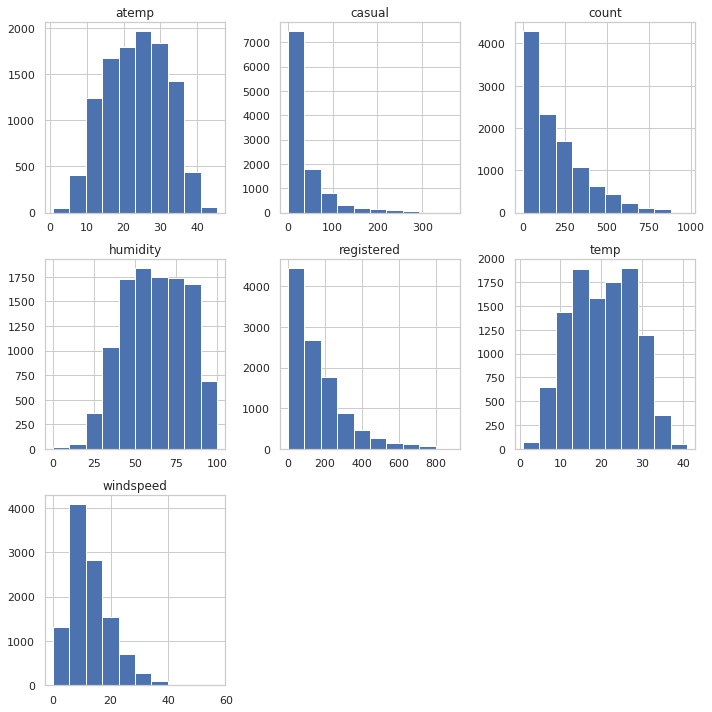

In [10]:
# distribution of data
# y값이 count이므로 포아송 분포가 적합할 가능성 있음
# log(y+1) 변환을 통해 정규분포 모양에 가깝게 하면 성능 좋을 가능성 높음
fig, ax = plt.subplots(figsize=(10, 10))
df.hist(ax=ax)
plt.tight_layout()
plt.show()

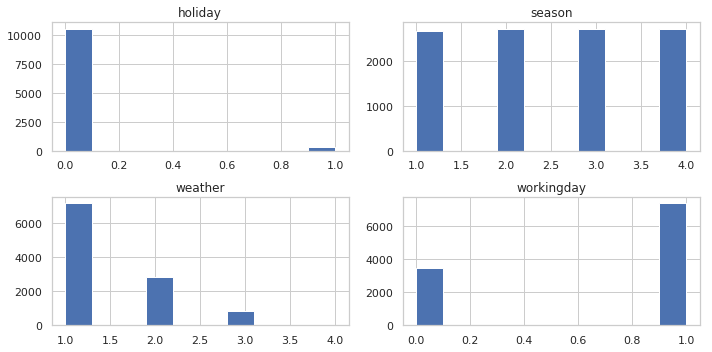

In [61]:
# distribution of categorical data
col = ['season', 'holiday', 'weather', 'workingday']
fig, ax = plt.subplots(figsize=(10, 5))
df_train[col].hist(ax=ax)
plt.tight_layout()
plt.show()

- #### `training` dataset:
    - 매월 1일~19일
- #### `test` dataset:
    - 매월 20일~30/31일

In [2]:
# Train data: 10886 sample
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null datetime64[ns]
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.6 KB


In [47]:
df_raw.tail()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129
10885,2012-12-19 23:00:00,4,0,1,1,13.12,16.665,66,8.9981,4,84,88


# Conclusion
---------------------------------------

#### 테스트 퍼포먼스
- 채점 방식: Root Mean Squared Logarithmic Error (RMSLE).

### Base Model
- 1.15894

![worst performance](k_worst.png)

### Best Model
    - 0.49410
    - 1471등/3251명 (상위 45%)

![best performance](k_best.png)

In [66]:
f = 'np.log(count) ~ C(season1) + C(hour) +  C(new_col)*scale(perfect_atemp) + C(new_humidity)*scale(hum_sqr) + C(new_col)*scale(windspeed) + C(year) -1'
train_result = OLS_test(df_train, f)
train_result.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(count)   R-squared:                       0.898
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     1482.
Date:                Fri, 15 Mar 2019   Prob (F-statistic):               0.00
Time:                        01:27:22   Log-Likelihood:                -7376.8
No. Observations:               10886   AIC:                         1.488e+04
Df Residuals:                   10821   BIC:                         1.536e+04
Df Model:                          64                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
C(season1)[1]                            3.6524      0.039     93.770      0.000       3.576       3.729
C(season1)[2]                            3.5510      0.041     86.305      0.000       3.470       3.632
C(season1)[3]                            3.5462      0.039     90.473      0.000       3.469       3.623
C(hour)[T.1]                            -0.6533      0.032    -20.598      0.000      -0.715      -0.591
C(hour)[T.2]                            -0.9626      0.033    -29.112      0.000      -1.027      -0.898
C(hour)[T.3]                            -1.5179      0.033    -45.451      0.000      -1.583      -1.452
C(hour)[T.4]                            -1.8122      0.033    -54.489      0.000      -1.877      -1.747
C(hour)[T.5]                            -0.7080      0.033    -21.388      0.000      -0.773      -0.643
C(hour)[T.6]                            -0.8019      0.039    -20.754      0.000      -0.878      -0.726
C(hour)[T.7]                            -0.6402      0.041    -15.696      0.000      -0.720      -0.560
C(hour)[T.8]                            -0.2414      0.041     -5.906      0.000      -0.321      -0.161
C(hour)[T.9]                            -0.5010      0.049    -10.161      0.000      -0.598      -0.404
C(hour)[T.10]                           -0.3215      0.042     -7.712      0.000      -0.403      -0.240
C(hour)[T.11]                           -0.2121      0.042     -5.065      0.000      -0.294      -0.130
C(hour)[T.12]                           -0.7580      0.052    -14.705      0.000      -0.859      -0.657
C(hour)[T.13]                           -0.7875      0.052    -15.238      0.000      -0.889      -0.686
C(hour)[T.14]                           -0.8817      0.052    -17.022      0.000      -0.983      -0.780
C(hour)[T.15]                           -0.8307      0.052    -16.026      0.000      -0.932      -0.729
C(hour)[T.16]                           -0.8968      0.046    -19.310      0.000      -0.988      -0.806
C(hour)[T.17]                           -0.4875      0.046    -10.541      0.000      -0.578      -0.397
C(hour)[T.18]                           -0.3635      0.045     -8.109      0.000      -0.451      -0.276
C(hour)[T.19]                           -0.6367      0.045    -14.289      0.000      -0.724      -0.549
C(hour)[T.20]                           -0.6116      0.049    -12.409      0.000      -0.708      -0.515
C(hour)[T.21]                           -0.0916      0.039     -2.323      0.020      -0.169      -0.014
C(hour)[T.22]                           -0.3332      0.039     -8.464      0.000      -0.410      -0.256
C(hour)[T.23]                           -0.7401      0.039    -18.816      0.000      -0.817      -0.663
C(new_col)[T.2]                       

### Major Insight

> #### Hour by week&weekend
> - 주말과 평일에 형태가 다르다.
> - 평일에는 출퇴근시간대에 많이 빌리고, 주말에는 오후 시간에 수요가 많다는 insight를 얻었다.

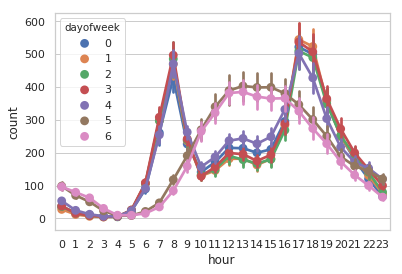

In [4]:
sns.pointplot(data=df_train,x='hour',y='count',hue='dayofweek')

> #### Holiday by holiday&workingday
> - 노동장의 날: 전형적인 쉬는날의 형태 (출퇴근시간에 적고, 오후시간에 많음.)
> - 해방의 날: holiday로 분류되어있음에도 불구하고, workingday와 같은 형태를나타냄.

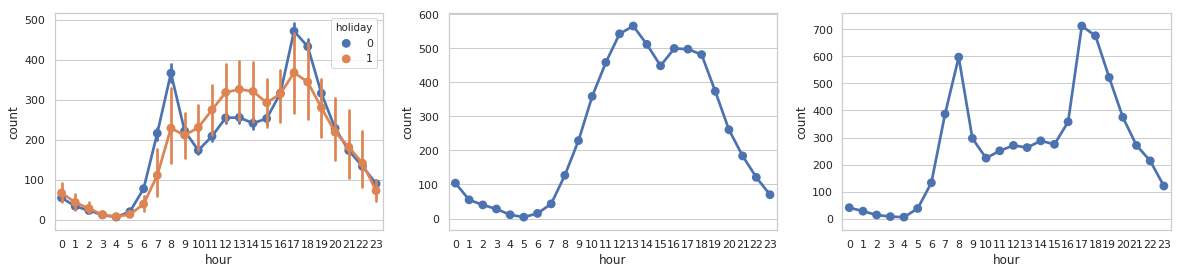

In [6]:
plt.figure(figsize=(20, 4))
plt.subplot(131)
sns.pointplot(data=df_train, x='hour',y='count',hue= 'holiday')

#노동장의 날
plt.subplot(132)
plots1 = df_train[(df_train['month']==9)& (df_train['day']==3) &(df_train['year']==2012)]
sns.pointplot(data=plots1, x='hour',y='count')

# 노예 해방의 날
plt.subplot(133)
plots = df_train[(df_train['month']==4)& (df_train['day']==16) &(df_train['year']==2012)] #일하는날 형태
sns.pointplot(data=plots, x='hour',y='count')

> #### Humidity & Atemp & Windspeed
> - 습도는 아주 건조한 날은 대여량이 매우 적고, 그 뒤에는 점진적으로 줄어든다.
> - 바람의 속도는 아주 큰 량에서 이상치가 보인다(하지만 처리해도 퍼포먼스가 좋아지지는 않는다.)

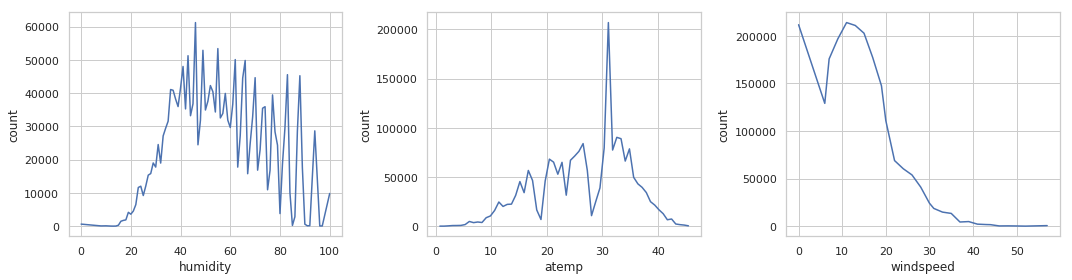

In [55]:
plt.figure(figsize=(15, 4))
plt.subplot(131)
sns.lineplot(x='humidity', y='count', estimator='sum', data=df_raw, ci=None)
plt.subplot(132)
sns.lineplot(x='atemp', y='count', estimator='sum', data=df_raw, ci=None)
plt.subplot(133)
sns.lineplot(x='windspeed', y='count', estimator='sum', data=df_raw, ci=None)
plt.tight_layout()
plt.show()

# Main Subject
-------

### 1. 자료탐색

- #### 1) 데이터 관계 파악
- #### 2) 주요 EDA 내용
>    - (1) windspeed
>    - (2) humidity
>    - (3) atemp
>       
- #### 3) 상관관계
>    - (1) correlation
>    - (2) VIF
- #### 4) 카테고리별 독립성
-----

### 2. 모델구축
----
-----
### 3. 결과진단 잔차분석(resid vs y hat)
- #### 1) 정규성(qq plot, omnibus)
- #### 2) 등분산성(잔차 vs 예측치)
- #### 3) 적합성 여부(독립변수 vs 예측치)
-----
### 4. 변수추가 상세
-----
### 5. 최종모델 진단

## 1. 자료탐색
-----

> ### 1) 데이터 관계 파악
    - atemp, temp 다중공선성 발생(*temp drop)
    - 독립변수(연속변수)와 종속변수(count)의 선형관계 찾기 어려움(*카테고리별 추가 필요함)

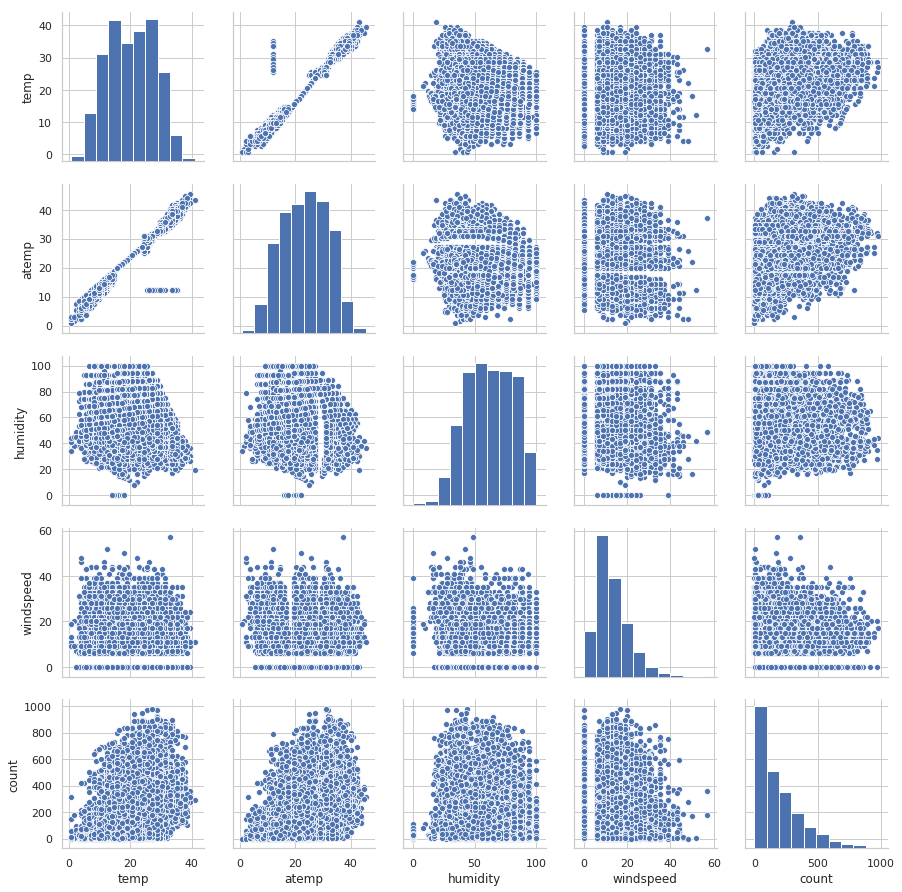

In [7]:
# y에 대해 선형성이 안보임
sns.pairplot(data=df_raw1)
plt.show()

> ### 2) 주요 EDA 내용(연속변수: windspeed, attemp, humidity)

> #### (1) humidity
- 이상치: 2011.3.10 데이터 0
- 해결
    - 날씨 사이트에서 해당 날짜의 humidity의 평균 입력

> #### (2) windspeed
- 이상치: 0
- 해결
    - 앞뒤 한 시간의 평균치 
    - 해당 날짜의 풍속 평균치
    
> #### (3)  atemp 
- 이상치: 12개 데이터 '12.12'도 입력
- 해결
    - 체감온도 공식 사용하여 입력 
    - 13.12 + 0.6215*float(df['temp']) - 11.37*(float(df["windspeed"])**0.16) + 0.3965*float(df["temp"])*(float(df["windspeed"])**0.16)ㅡ

> - #### (1) humidity

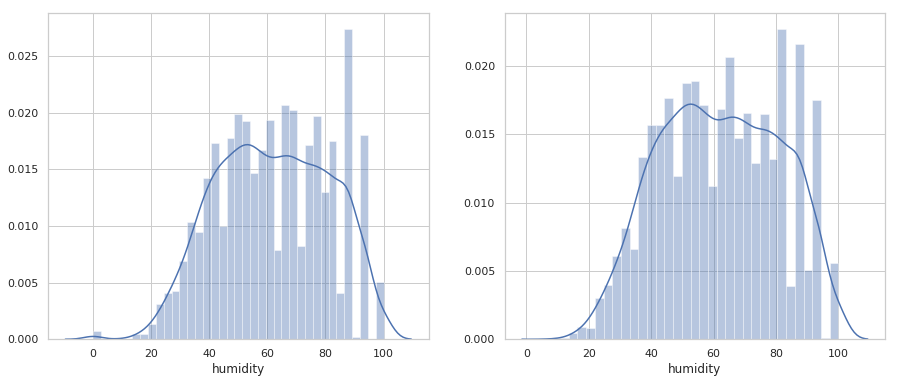

In [8]:
plt.figure(figsize=(15, 6))
plt.subplot(121)
sns.distplot(df_raw['humidity'])
plt.subplot(122)
sns.distplot(df_train['humidity'])
plt.show()

> - (2) windspeed

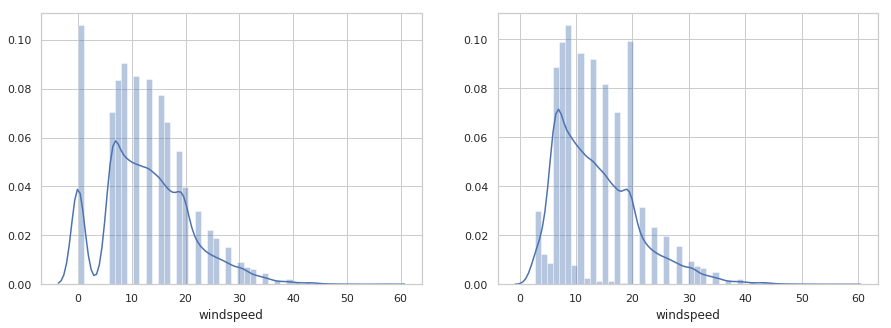

In [9]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
sns.distplot(df_raw['windspeed'])
plt.subplot(122)
sns.distplot(df_train['windspeed'])
plt.show()

> - (3) atemp

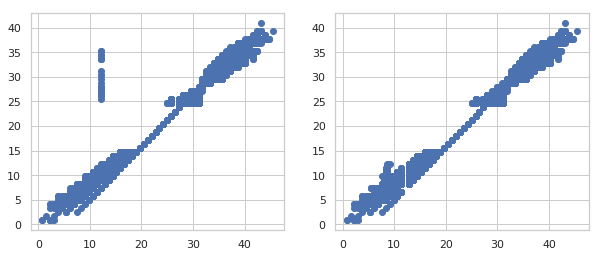

In [10]:
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.scatter(x='atemp', y='temp', data=df_train)
plt.subplot(122)
plt.scatter(x='adjusted_atemp', y='temp', data=df_train)
plt.show()

> ### 3) 상관관계
    - atemp와 temp 상관관계 높음(*temp 누락)

> - (1) correlation

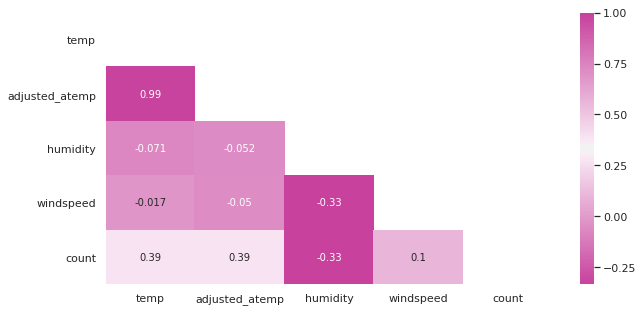

In [11]:
plt.figure(figsize=(10, 5))
cor_mat = df_train[['temp', 'adjusted_atemp', 'humidity', 'windspeed', 'count']].corr()
mask = np.zeros_like(cor_mat, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(330, 330, as_cmap=True)
sns.heatmap(data=cor_mat, mask=mask, annot=True, cmap=cmap)
plt.show()

> - (2) VIF

In [12]:
df_raw1.columns

Index(['temp', 'atemp', 'humidity', 'windspeed', 'count'], dtype='object')

In [13]:
# VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(df_raw1[df_raw1.columns[:-1]].values, i)\
                                                      for i in range(df_raw1[df_raw1.columns[:-1]].shape[1])]
vif["features"] = df_raw1[df_raw1.columns[:-1]].columns
vif

,VIF Factor,features
0,263.585580,temp
1,285.638206,atemp
2,5.749326,humidity
3,2.717068,windspeed


In [14]:
# VIF: temp제거
df_raw1.drop('temp', axis=1, inplace=True)
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(df_raw1[df_raw1.columns[:-1]].values, i)\
                                                      for i in range(df_raw1[df_raw1.columns[:-1]].shape[1])]
vif["features"] = df_raw1[df_raw1.columns[:-1]].columns
vif

,VIF Factor,features
0,5.801852,atemp
1,5.200188,humidity
2,2.687013,windspeed


> ### 4) 카테고리별 독립성

In [15]:
def chi2_test(df = df_train, cat1='hour', cat2='holiday', values='count'):
        """
        params: dataframe, 범주형 컬럼명1, 범주형 컬럼명2, 값
        귀무가설: 범주1, 2는 독립이다.
        return: g 카이제곱값, p p-value
        """
        chi2_df = df.pivot_table(values=values, index=cat1, columns=cat2, aggfunc=np.mean, fill_value=0)
        g, p, dof, expected = sp.stats.chi2_contingency(chi2_df)    
        return p

In [16]:
def cate_cor(*cols):
    col = list(cols)
    df = pd.DataFrame(columns=col, index=col)
    ls = []
    for i in col:
        for j in col:
            if i == j:
                ls.append(0)
            else:
                ls.append(chi2_test(cat1 = i, cat2 = j))
        df[i] = ls
        ls = []
        
    return df
    
new = cate_cor('hour','new_col','new_humidity','year')
old = cate_cor('season','holiday','workingday','weather','year','hour')

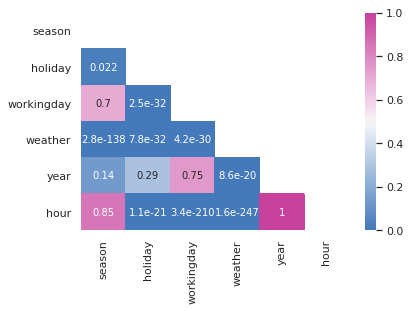

In [17]:
mask = np.zeros_like(old, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(250, 330, as_cmap=True)
sns.heatmap(data=old, mask=mask, annot=True, cmap=cmap)
plt.show()

## 2. 모델구축
- Formula  = 'count ~ C(hour) + scale(atemp) + scale(humidity) + I(scale(windspeed)**3) + C(year) + C(season)'

In [132]:
# base model
f

'count ~ C(hour) + scale(atemp) + scale(humidity) + C(year) + C(season) + C(workingday)'

In [139]:
stats_kfold(df, f, 'count')

train R2 = 0.27125826, test R2 = 0.26880405
train R2 = 0.26555476, test R2 = 0.29328456
train R2 = 0.26907684, test R2 = 0.27755667
train R2 = 0.27853892, test R2 = 0.24052005
train R2 = 0.27054192, test R2 = 0.27184477


In [133]:
def stats_kfold(data=df, formula=f, y_col_name='SalePrice'):
    from sklearn.model_selection import KFold

    scores = np.zeros(5)
    cv = KFold(5, shuffle=True, random_state=0)
    
    for i, (idx_train, idx_test) in enumerate(cv.split(df)):
        df_train = df.iloc[idx_train]
        df_test = df.iloc[idx_test]
        
        # 모델 변경 필요
        model = sm.OLS.from_formula(f, data=df_train)
        # ridge
        # result = model.fit_regularized(alpha=10, L1_wt=0)
        result = model.fit()
        
        pred = result.predict(df_test)
        rss = ((df_test[y_col_name] - pred)**2).sum()
        tss = ((df_test[y_col_name] - df_test[y_col_name].mean())**2).sum()
        rsquared = 1 - rss / tss
        
        scores[i] = rsquared
        # print("test R2 = {:.8f}".format(rsquared))
        print("train R2 = {:.8f}, test R2 = {:.8f}".format(result.rsquared, rsquared))



In [ ]:
from sklearn.model_selection import KFold

scores = np.zeros(5)
cv = KFold(5, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(df)):
    df_train = df.iloc[idx_train]
    df_test = df.iloc[idx_test]
    
    model = sm.OLS.from_formula("MEDV ~ " + "+".join(boston.feature_names), data=df_train)
    result = model.fit()
    
    pred = result.predict(df_test)
    rss = ((df_test.MEDV - pred) ** 2).sum()
    tss = ((df_test.MEDV - df_test.MEDV.mean())** 2).sum()
    rsquared = 1 - rss / tss
    
    scores[i] = rsquared
    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(result.rsquared, rsquared))

In [138]:
f = 'count ~  scale(atemp) + scale(humidity) + C(season) + C(workingday)'
train_result = OLS_test(df_train, f)
train_result.summary()  

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.276
Model:                            OLS   Adj. R-squared:                  0.276
Method:                 Least Squares   F-statistic:                     692.3
Date:                Wed, 12 Dec 2018   Prob (F-statistic):               0.00
Time:                        00:43:44   Log-Likelihood:                -70285.
No. Observations:               10886   AIC:                         1.406e+05
Df Residuals:                   10879   BIC:                         1.406e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            182.5237      4.465     40.881      0.000     173.772     191.275
C(season)[T.2]         0.1438      5.304      0.027      0.978     -10.252      10.540
C(season)[T.3]       -27.5967      6.496     -4.248      0.000     -40.331     -14.863
C(season)[T.4]        63.6568      4.498     14.151      0.000      54.839      72.474
C(workingday)[T.1]    -0.0656      3.172     -0.021      0.984      -6.283       6.152
scale(atemp)          81.7727      2.366     34.559      0.000      77.135      86.411
scale(humidity)      -58.2402      1.527    -38.147      0.000     -61.233     -55.248
==============================================================================
Omnibus:                     2184.135   Durbin-Watson:                   0.444
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4287.141
Skew:                           1.215   Prob(JB):                         0.00
Kurtosis:                       4.883   Cond. No.                         8.34
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 3. 결과진단 잔차분석

> ### 1) 정규성(qq plot, omnibus)

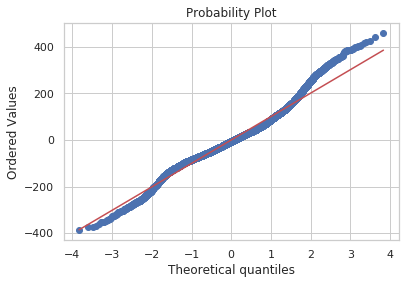

In [19]:
# QQ플롯
sp.stats.probplot(train_result.resid, plot=plt)
plt.show()

In [20]:
## 정규성 테스트
test = sm.stats.omni_normtest(train_result.resid)
print("statistics: ", test.statistic, "p-value: ", test.pvalue)

statistics:  692.4847397717937 p-value:  4.254508125662871e-151


> ### 2) 등분산성(잔차 vs 예측치)

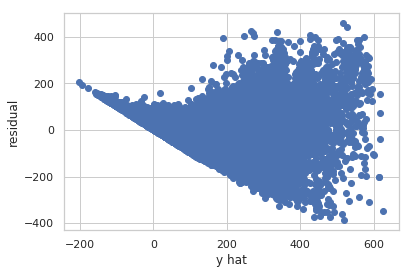

In [21]:
# 이분산성을 보임
plt.scatter(x=train_result.fittedvalues, y=train_result.resid)
plt.xlabel("y hat")
plt.ylabel("residual")
plt.show()

> ### 3) 적합성 여부(독립변수 vs 예측치)

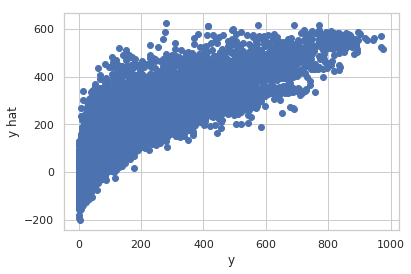

In [22]:
# y와 y hat 간에 로그함수 관계가 보임
plt.scatter(x=df_raw['count'], y=train_result.fittedvalues)
plt.xlabel('y')
plt.ylabel('y hat')
plt.show()

## 4. 변수추가 상세: 선형성을 찾기 위해 category 변수 활용
#### 1) new category1: hour와 week/weekend 활용하여 생성
- 각 count의 4분위에 해당하는 hour를 4 구간으로 나눔
- eg. 
    - 주중 peaktime: [7, 8, 16, 17, 18, 19]
    - 주중 peaktime: [12, 13, 14, 15, 16, 17]
----
#### 2) new_humidity: season과 weather를 활용하여 생성 
- humadity와 y의 선형관계를 보여주는 카테고리 생성

> #### new category1

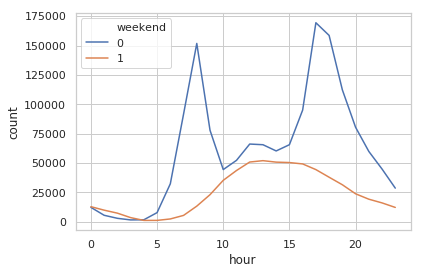

In [23]:
sns.lineplot(x='hour', y='count', hue='weekend',data=df_train, estimator='sum', ci=None)
plt.show()

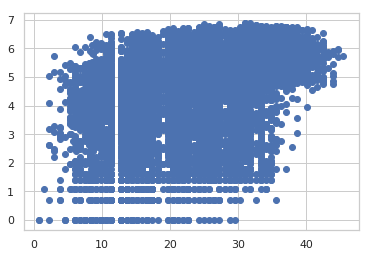

In [24]:
plt.scatter(df_train['adjusted_atemp'], df_train['count_log'])
plt.show()

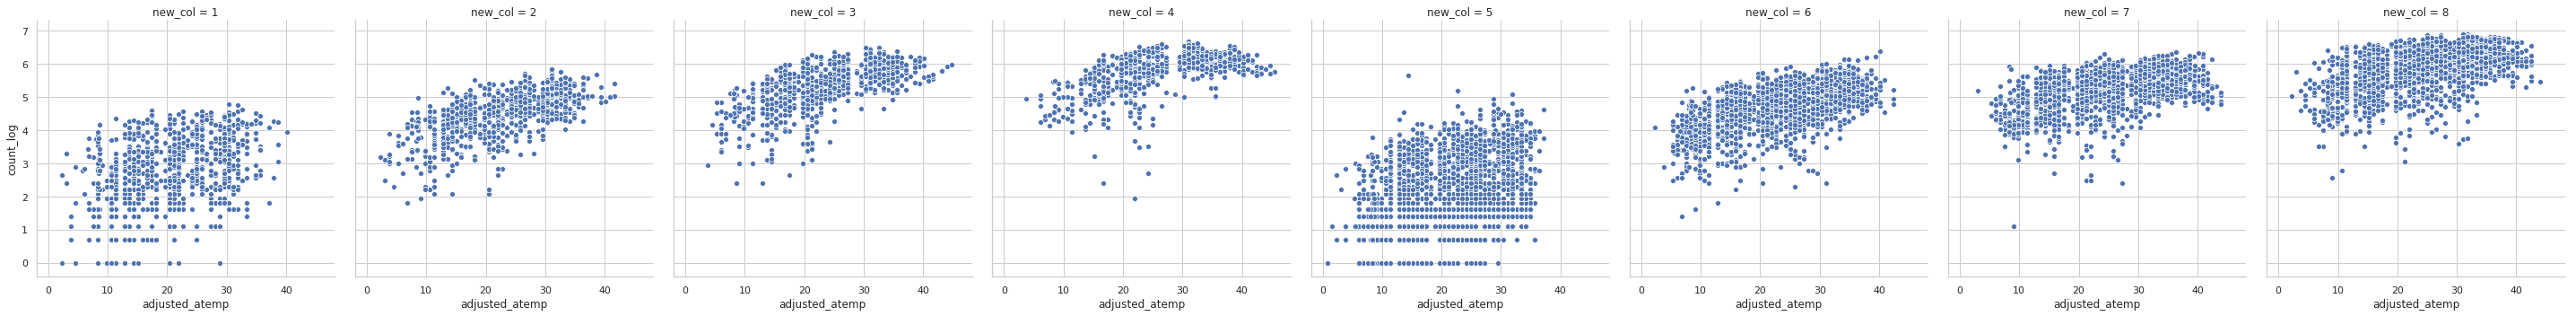

In [25]:
sns.relplot(x='adjusted_atemp', y='count_log', col='new_col', data=df_train)
plt.show()

> #### new category2

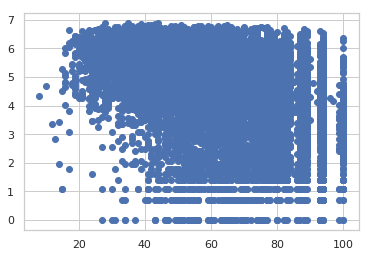

In [26]:
plt.scatter(x='humidity', y='count_log', data=df_train)
plt.show()

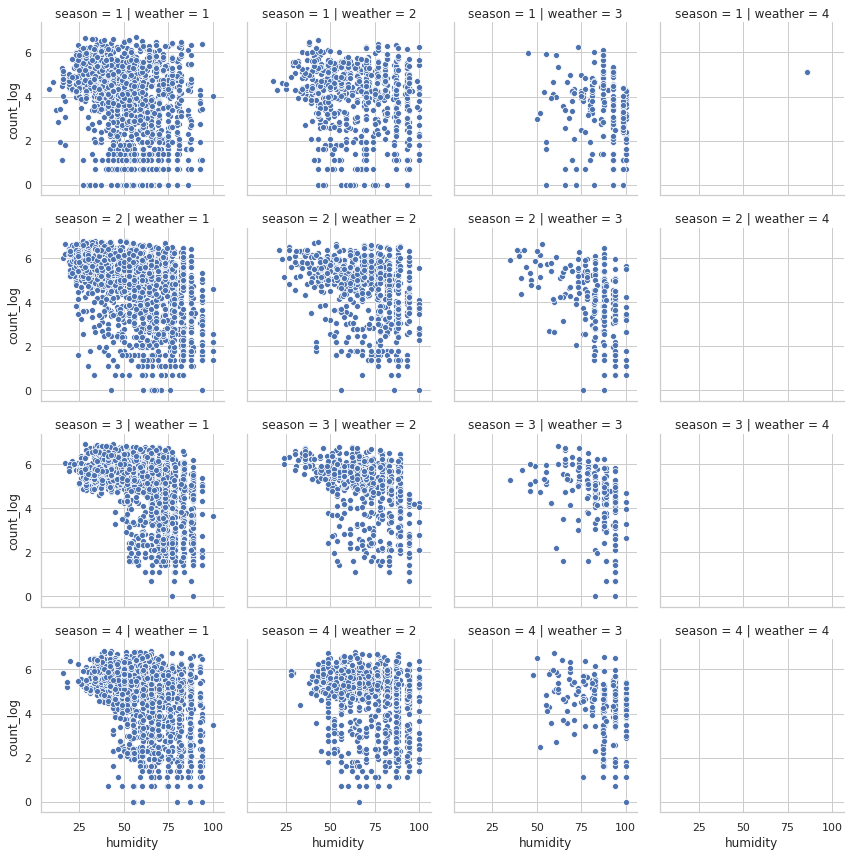

In [27]:
g = sns.FacetGrid(row='season', col='weather', data=df_train)
g.map(sns.scatterplot, 'humidity', 'count_log')
plt.show()

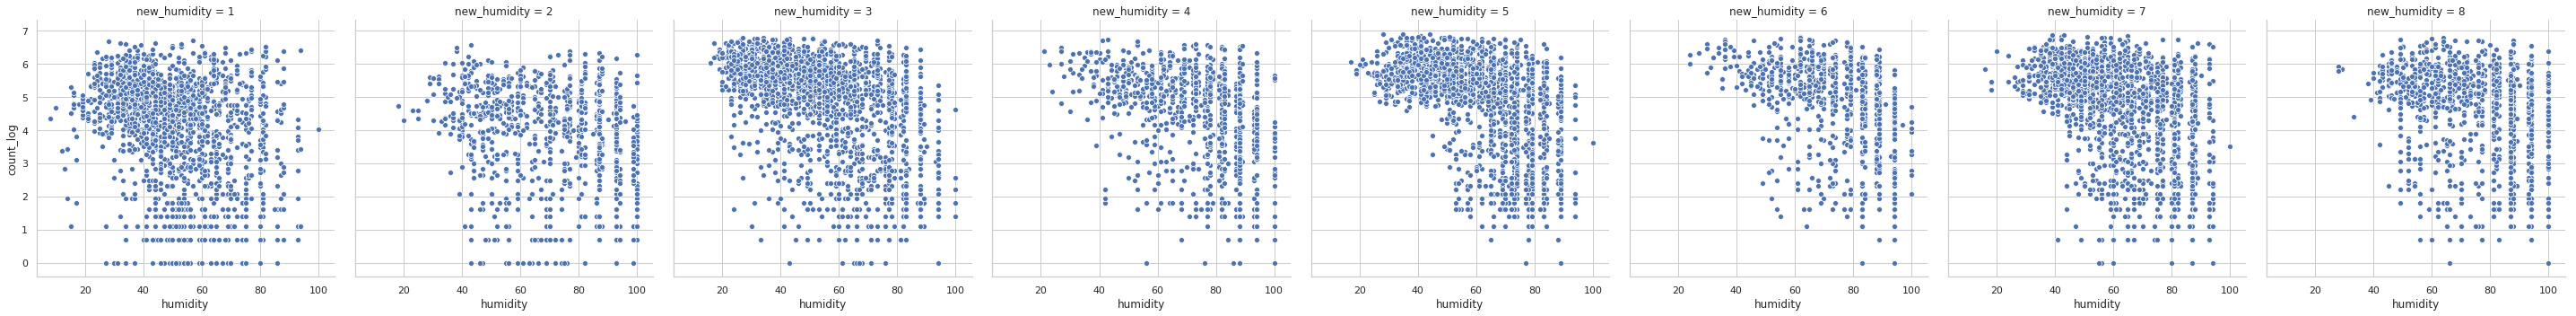

In [28]:
sns.relplot(x='humidity', y='count_log', col='new_humidity', data=df_train)
plt.show()

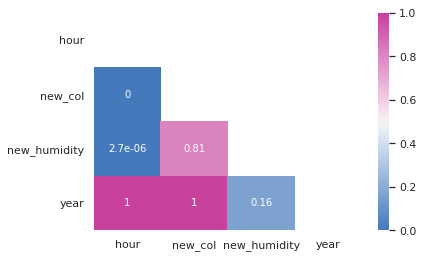

In [29]:
mask = np.zeros_like(new, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(250, 330, as_cmap=True)
sns.heatmap(data=new, mask=mask, annot=True, cmap=cmap)
plt.show()

## 5. 최종모델 진단

In [30]:
f = 'np.log(I(count)) ~ 0 + C(season1) + C(hour) + C(new_col)/I(np.log(scale(perfect_atemp))) + C(new_humidity)/scale(hum_sqr) + C(new_col):scale(windspeed) + C(year)'
train_result = OLS_test(df_train, f)

Text(0, 0.5, 'residuals')

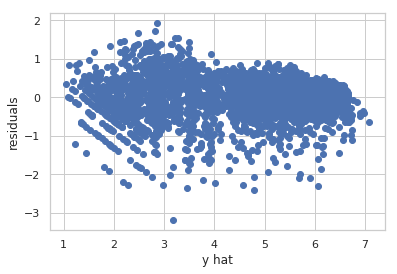

In [31]:
# y hat vs residuals: 이분산 문제 조금 더 괜찮아짐
plt.scatter(train_result.fittedvalues, train_result.resid)
plt.xlabel('y hat')
plt.ylabel('residuals')

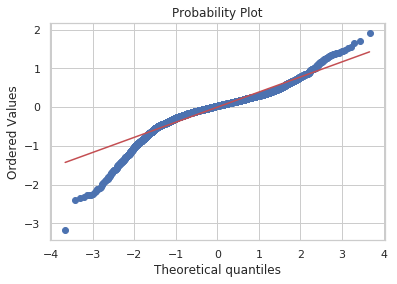

In [33]:
# QQ plot
sp.stats.probplot(train_result.resid, plot=plt)
plt.show()

![final](final.png)

## 한계

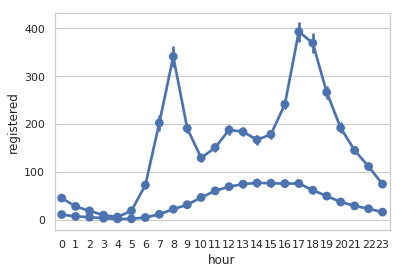

In [32]:
sns.pointplot(data=df_train, x='hour',y='casual')
sns.pointplot(data=df_train, x='hour', y='registered')

> 회원과 비회원이 빌리는 형태가 다르다.(사용하는 사람들의 형태가 다르다고 해석된다.)

#### 이분산성을 잡기위해서 Trans_log변형을 진행했는데, 이렇게 되면 resid값이 큰값에서는 작게 된다.
- ex)
    - log 1000 - log 100 ==> 900차이
    - log10 - log1 ==> 9차이
    - 1번이 900이라는 큰 예측값의 차이를 나타냈지만  resid값은 1로 같다.
    - resid를 통해서 outlier처리를 해줘도 퍼포먼스가 올라가지 않는다. ($R^2$값은 올라간다)


#### 카테고리 값에서 비선형성을 띌 경우, 처리를 해주지 못했다.
- sin(2$\pi$*x/T) + sin(2$\pi$*x/T)를 통해서 cyclic ordinary데이터를 처리했는데, 오히려 퍼포먼스가 현저히 떨어짐을 확인했는데, 그 원인을 발견하지 못함.